In [1]:
from matplotlib import pyplot as plt
from itertools import product
# import seaborn as sns
import pandas as pd
import os.path as op
import argparse
import re
import numpy as np
import matplotlib.pyplot as plt
import mne
import seaborn as sns
from scipy import signal, stats
from scipy.fft import fftshift
from bids import BIDSLayout
from statsmodels.stats.anova import AnovaRM

from util.io.ffr import *

#### Compute ERP peaks

In [2]:
# # Read data
# evokeds = pd.read_csv('evokeds.csv')
# evokeds['uV'] = evokeds['uV'] * 1000000
# evokeds = evokeds[evokeds.chan == 'Cz']

# all_peaks = pd.DataFrame()
# tones = [1, 2, 3]
# predictability = [True, False]
# segments = [("max", 50, 100), ("min", 70, 150), ("max", 120, 250), ("min", 220, 420), ("inflection", 360, 360), ("inflection", 385, 385), ("inflection", 400, 400), ("inflection", 405, 405)]

# for tone in tones:
#     for target in tones:
#         for predictable in predictability:
#             for segment in segments:
#                 peak_type = segment[0]
#                 start = segment[1]
#                 end = segment[2]

#                 # Segment the data
#                 cond_evokeds = evokeds[(evokeds.tone == tone) &
#                             (evokeds.target == target) &
#                             (evokeds.predictable == predictable)]

#                 # Take a time slice
#                 seg = cond_evokeds[cond_evokeds.msec >= start]
#                 seg = seg[seg.msec <= end]
                
#                 # Calculate the max for each subject
#                 if peak_type == "max":
#                     peaks = seg.groupby(['sub'], as_index = False)['uV'].max()
#                 elif peak_type == "min":
#                     peaks = seg.groupby(['sub'], as_index = False)['uV'].min()
#                 elif peak_type == "inflection":
#                     peaks = seg[seg.msec == segment[1]]
#                     peaks = peaks.drop(columns = ['chan', 'accuracy', 'msec'])

#                 # Create a data frame
#                 peaks['tone'] = tone
#                 peaks['target'] = target
#                 peaks['predictable'] = predictable
#                 peaks['peak_type'] = peak_type
#                 peaks['start'] = start
#                 peaks['end'] = end

#                 # Bind to data frame
#                 all_peaks = pd.concat([all_peaks, peaks])
#                 all_peaks = all_peaks.reset_index(drop = True)
#     #             break
#     #         break
#     #     break
#     # break
# all_peaks.to_csv('erp_peaks.csv', index = False)
erp_peaks = pd.read_csv('erp_peaks.csv')
erp_peaks

,sub,uV,tone,target,predictable,peak_type,start,end
0,10,1.231935,1,1,True,max,50,100
1,11,1.317055,1,1,True,max,50,100
2,12,0.110292,1,1,True,max,50,100
3,13,1.223468,1,1,True,max,50,100
4,14,0.734647,1,1,True,max,50,100
...,...,...,...,...,...,...,...,...
4531,37,-0.455917,3,3,False,inflection,405,405
4532,38,0.455280,3,3,False,inflection,405,405
4533,39,0.080501,3,3,False,inflection,405,405
4534,40,0.122103,3,3,False,inflection,405,405


#### Compute FFR spectrum peaks

In [3]:
# spectrums = pd.read_csv('spectrums.csv', sep = '\t')
# all_stims_power = pd.DataFrame()
# stim_freqs = [110, 150, 210]

# for stim_freq in stim_freqs:    
#     print(f'{stim_freq} Hz stimulus')

#     # select Fourier frequency nearest to stimulus frequency 
#     idx = np.abs(spectrums.frequency - stim_freq).argmin()
#     hz = spectrums.frequency[idx]
#     power_f0 = spectrums[spectrums.frequency == hz]
#     power_f0 = power_f0[power_f0.tone == stim_freq]

#     # append to df
#     all_stims_power = pd.concat([all_stims_power, power_f0])
#     all_stims_power = all_stims_power.reset_index(drop = True)
# all_stims_power.to_csv('ffr_peaks.csv', index = False)
ffr_peaks = pd.read_csv('ffr_peaks.csv')
ffr_peaks

,subject,predictable,target,tone,frequency,dB
0,2,True,110,110,109.780439,-2.185842
1,2,True,150,110,109.780439,1.132664
2,2,True,210,110,109.780439,-0.974214
3,2,False,110,110,109.780439,-2.950545
4,2,False,150,110,109.780439,1.369111
...,...,...,...,...,...,...
715,41,True,150,210,209.580838,5.132328
716,41,True,210,210,209.580838,3.544135
717,41,False,110,210,209.580838,5.581544
718,41,False,150,210,209.580838,0.152358


#### Combine into one dataframe

In [4]:
# # Combine into one dataframe
# print(len(np.unique(ffr_peaks.subject)))
# print(len(np.unique(erp_peaks['sub'])))
# all_peaks = pd.DataFrame()

# for sub in np.unique(ffr_peaks.subject):
#     # Subset data
#     sub_ffr_peaks = ffr_peaks[ffr_peaks.subject == sub]
#     sub_erp_peaks = erp_peaks[erp_peaks['sub'] == sub]

#     # Match columns
#     sub_erp_peaks = sub_erp_peaks.rename(columns = {'sub': 'subject'})
#     sub_erp_peaks['tone'] = sub_erp_peaks['tone'].replace({1: 110, 2: 150, 3: 210})
#     sub_erp_peaks['target'] = sub_erp_peaks['target'].replace({1: 110, 2: 150, 3: 210})

#     # Merge dfs
#     sub_peaks = sub_erp_peaks.merge(sub_ffr_peaks, left_on = ["subject", "predictable", "tone", "target"], right_on = ["subject", "predictable", "tone", "target"])
#     all_peaks = pd.concat([all_peaks, sub_peaks])
#     all_peaks = all_peaks.reset_index(drop = True)

# all_peaks.to_csv('all_peaks.csv', index = False)
all_peaks = pd.read_csv('all_peaks.csv')
all_peaks

,uV,peak_type,start,end,subject,predictable,target,tone,frequency,dB
0,1.231935,max,50,100,10,True,110,110,109.780439,3.188191
1,-0.009922,min,70,150,10,True,110,110,109.780439,3.188191
2,0.697509,max,120,250,10,True,110,110,109.780439,3.188191
3,-0.266403,min,220,420,10,True,110,110,109.780439,3.188191
4,0.169443,inflection,360,360,10,True,110,110,109.780439,3.188191
...,...,...,...,...,...,...,...,...,...,...
4531,-0.691765,min,220,420,41,False,210,210,209.580838,0.645166
4532,0.592332,inflection,360,360,41,False,210,210,209.580838,0.645166
4533,0.449019,inflection,385,385,41,False,210,210,209.580838,0.645166
4534,0.179435,inflection,400,400,41,False,210,210,209.580838,0.645166


In [5]:
# Drop subjects with fewer than 80% trials
BADS = [33, 37]
for bad in BADS:
    all_peaks = all_peaks[all_peaks['subject'] != bad]
np.unique(all_peaks['subject'])

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40, 41])

In [6]:
# Drop subject with anomalous data based on IQR
all_peaks = all_peaks[all_peaks['subject'] != 32]
# all_peaks = all_peaks[all_peaks['subject'] != 24]

## Regressions

### Max at 80-130 sec against predictability

##### 110 Hz tone

0.03131495132497689 0.7373702822774608 0.2225405986913727 0.2459166313842804 0.026401652573090555
0.09999190737801995 0.6374775602520859 0.5988645166024943 0.0005985154154126387 0.02573390904207438


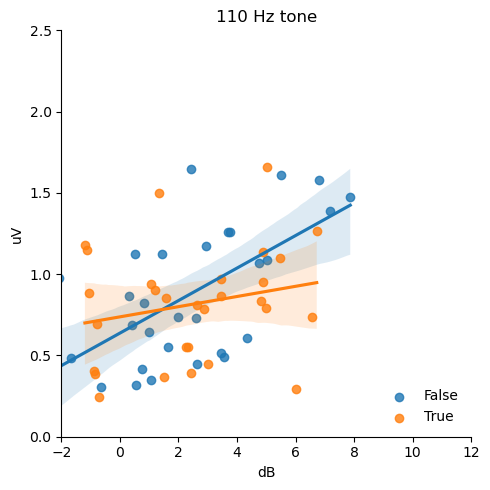

In [7]:
peaks_110 = all_peaks[all_peaks.tone == 110]

peak = peaks_110[peaks_110.start == 50] # 360, 385, 400
uV = peak.groupby(['subject', 'predictable'], as_index=False)['uV'].mean()
dB = peak.groupby(['subject', 'predictable'], as_index=False)['dB'].mean()
df = uV
df['dB'] = dB.dB

# Plot
graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "predictable", legend = False)
graph.set(ylim = (0, 2.5), xlim = (-2, 12))
ax = plt.gca()
ax.set_title("110 Hz tone")
plt.legend(loc = 'lower right', frameon = False) 
plt.tight_layout()
plt.savefig('../figs/ERP-FFR-tone-1-by-predictability.png')

# Regression
df_predictable = df[df.predictable == True]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_predictable.dB, df_predictable.uV)
print(slope, intercept, r_value, p_value, std_err)
df_random = df[df.predictable == False]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_random.dB, df_random.uV)
print(slope, intercept, r_value, p_value, std_err)

##### 150 Hz tone

0.017337255415152356 0.6799595820572721 0.11592812713691159 0.5492689340404793 0.028587195017427378
0.055317605705369755 0.7350984606048377 0.33530907506138724 0.07537918361994346 0.02991141508486334


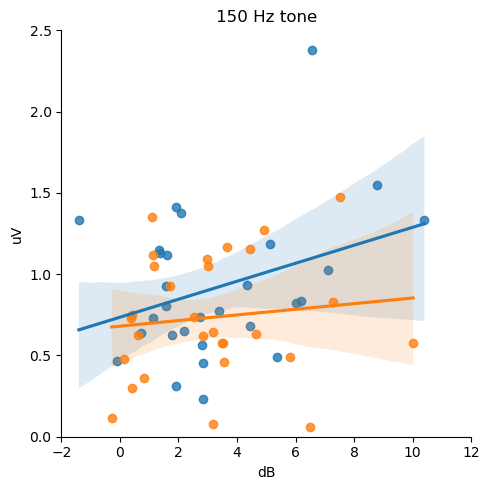

In [8]:
peaks_150 = all_peaks[all_peaks.tone == 150]

peak = peaks_150[peaks_150.start == 50] # 360, 385, 400
uV = peak.groupby(['subject', 'predictable'], as_index=False)['uV'].mean()
dB = peak.groupby(['subject', 'predictable'], as_index=False)['dB'].mean()
df = uV
df['dB'] = dB.dB

# Plot
graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "predictable", legend = False)
graph.set(ylim = (0, 2.5), xlim = (-2, 12))
ax = plt.gca()
ax.set_title("150 Hz tone")
plt.tight_layout()
plt.savefig('../figs/ERP-FFR-tone-2-by-predictability.png')

# Regression
df_predictable = df[df.predictable == True]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_predictable.dB, df_predictable.uV)
print(slope, intercept, r_value, p_value, std_err)
df_random = df[df.predictable == False]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_random.dB, df_random.uV)
print(slope, intercept, r_value, p_value, std_err)

##### 210 Hz tone

0.021179892791865208 0.5996725374703065 0.22805622880556528 0.2341024389844086 0.017402109484926907
0.03196851246821212 0.8021652154454846 0.22165580272687405 0.24784784729254689 0.027065852975261637


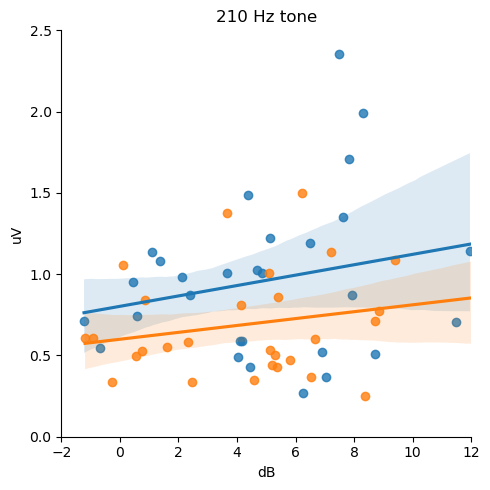

In [9]:
peaks_210 = all_peaks[all_peaks.tone == 210]

peak = peaks_210[peaks_210.start == 50] # 360, 385, 400
uV = peak.groupby(['subject', 'predictable'], as_index=False)['uV'].mean()
dB = peak.groupby(['subject', 'predictable'], as_index=False)['dB'].mean()
df = uV
df['dB'] = dB.dB

# Plot
graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "predictable", legend = False)
graph.set(ylim = (0, 2.5), xlim = (-2, 12))
ax = plt.gca()
ax.set_title("210 Hz tone")
plt.tight_layout()
plt.savefig('../figs/ERP-FFR-tone-3-by-predictability.png')

# Regression
df_predictable = df[df.predictable == True]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_predictable.dB, df_predictable.uV)
print(slope, intercept, r_value, p_value, std_err)
df_random = df[df.predictable == False]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_random.dB, df_random.uV)
print(slope, intercept, r_value, p_value, std_err)

### Inflection point at 360-400 msec against accuracy

In [10]:
all_peaks = pd.read_csv('all_peaks.csv')
all_peaks

,uV,peak_type,start,end,subject,predictable,target,tone,frequency,dB
0,1.231935,max,50,100,10,True,110,110,109.780439,3.188191
1,-0.009922,min,70,150,10,True,110,110,109.780439,3.188191
2,0.697509,max,120,250,10,True,110,110,109.780439,3.188191
3,-0.266403,min,220,420,10,True,110,110,109.780439,3.188191
4,0.169443,inflection,360,360,10,True,110,110,109.780439,3.188191
...,...,...,...,...,...,...,...,...,...,...
4531,-0.691765,min,220,420,41,False,210,210,209.580838,0.645166
4532,0.592332,inflection,360,360,41,False,210,210,209.580838,0.645166
4533,0.449019,inflection,385,385,41,False,210,210,209.580838,0.645166
4534,0.179435,inflection,400,400,41,False,210,210,209.580838,0.645166


##### 110 Hz tone

-0.02253407094588463 -0.23845040563578349 -0.1438587149498019 0.4321550012301373 0.028300999012368468
-0.029203984605649443 -0.3796053823394599 -0.19498585851023204 0.28487634906226084 0.026820168759385875
-0.022799633142326227 -0.49715449760436176 -0.17034197847780339 0.3512853359726468 0.02407972341370571


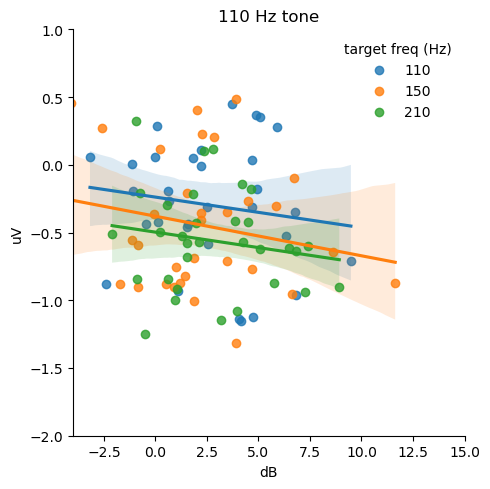

In [11]:
peaks_110 = all_peaks[all_peaks.tone == 110]

peak = peaks_110[peaks_110.start == 360] # 360, 385, 400
uV = peak.groupby(['subject', 'target'], as_index=False)['uV'].mean()
dB = peak.groupby(['subject', 'target'], as_index=False)['dB'].mean()
df = uV
df['dB'] = dB.dB

# Plot
graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "target", legend = False)
graph.set(ylim = (-2, 1), xlim = (-4, 15))
# 
ax = plt.gca()
ax.set_title("110 Hz tone")
plt.legend(loc = 'upper right', title = "target freq (Hz)", frameon = False) 
plt.tight_layout()
plt.savefig('../figs/ERP-FFR-tone-1.png')

# Regression
df_110 = df[df.target == 110]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_110.dB, df_110.uV)
print(slope, intercept, r_value, p_value, std_err)
df_150 = df[df.target == 150]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_150.dB, df_150.uV)
print(slope, intercept, r_value, p_value, std_err)
df_210 = df[df.target == 210]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_210.dB, df_210.uV)
print(slope, intercept, r_value, p_value, std_err)

#### 150 Hz tone

-0.010910847598926118 -0.348595299517325 -0.06373634460142252 0.7379230244547332 0.032285565907451685
-0.06172229494368108 0.18055826699085586 -0.3863773582248271 0.034941125896926266 0.027844716317128065
-0.024532485052819058 -0.2771426165578362 -0.14248091108799518 0.45260196707537925 0.03220714423308388


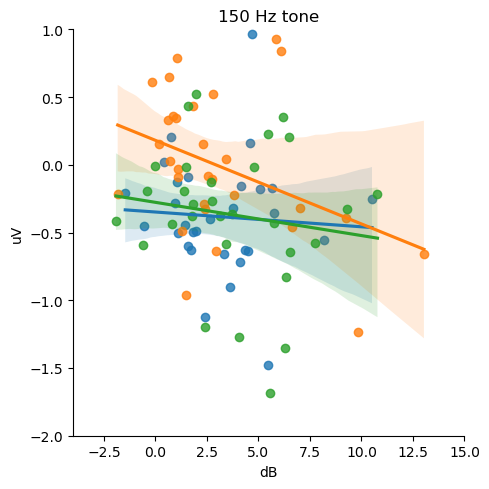

In [12]:
peaks_150 = all_peaks[all_peaks.tone == 150]
peaks_150 = peaks_150[peaks_150 != 18]
peaks_150 = peaks_150[peaks_150 != 33]

peak = peaks_150[peaks_150.start == 400] # 360, 385, 400
uV = peak.groupby(['subject', 'target'], as_index=False)['uV'].mean()
dB = peak.groupby(['subject', 'target'], as_index=False)['dB'].mean()
df = uV
df['dB'] = dB.dB

# Plot
graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "target", legend = False)
graph.set(ylim = (-2, 1), xlim = (-4, 15))
ax = plt.gca()
ax.set_title("150 Hz tone")
plt.tight_layout()
plt.savefig('../figs/ERP-FFR-tone-2.png')

# Regression
df_110 = df[df.target == 110]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_110.dB, df_110.uV)
print(slope, intercept, r_value, p_value, std_err)
df_150 = df[df.target == 150]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_150.dB, df_150.uV)
print(slope, intercept, r_value, p_value, std_err)
df_210 = df[df.target == 210]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_210.dB, df_210.uV)
print(slope, intercept, r_value, p_value, std_err)

##### 210 Hz tone

-0.03390390740572371 -0.2838601545894117 -0.2714628381175424 0.13286119722084588 0.021946053371826105
-0.0099650032054081 -0.5431753270567423 -0.0807225825609656 0.6605266594120139 0.022464780346157405
-0.08151449331862336 0.1380688632429512 -0.4733987974728235 0.006207424995175066 0.02769160540275652


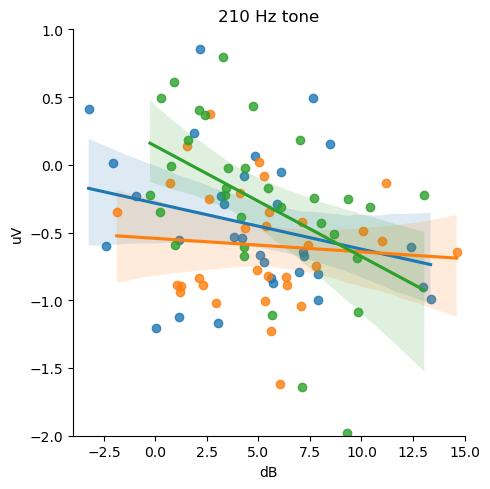

In [13]:
peaks_210 = all_peaks[all_peaks.tone == 210]

peak = peaks_210[peaks_210.start == 360]
uV = peak.groupby(['subject', 'target'], as_index=False)['uV'].mean()
dB = peak.groupby(['subject', 'target'], as_index=False)['dB'].mean()
df = uV
df['dB'] = dB.dB

# Plot
graph = sns.lmplot(data = df, x = "dB", y = "uV", hue = "target", legend = False)
graph.set(ylim = (-2, 1), xlim = (-4, 15))
ax = plt.gca()
ax.set_title("210 Hz tone")
plt.tight_layout()
plt.savefig('../figs/ERP-FFR-tone-3.png')

# Regression
df_110 = df[df.target == 110]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_110.dB, df_110.uV)
print(slope, intercept, r_value, p_value, std_err)
df_150 = df[df.target == 150]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_150.dB, df_150.uV)
print(slope, intercept, r_value, p_value, std_err)
df_210 = df[df.target == 210]
slope, intercept, r_value, p_value, std_err = stats.linregress(df_210.dB, df_210.uV)
print(slope, intercept, r_value, p_value, std_err)

#### Interactions with task performance

In [14]:
accuracies = pd.read_csv('accuracies.csv')
accuracies = accuracies.rename(columns = {'sub_num': 'subject'})
all_peaks = pd.read_csv('all_peaks.csv')
all_peaks = all_peaks.merge(accuracies, left_on = ['subject'], right_on = ['subject'])

In [15]:
# Drop subjects with fewer than 80% trials
BADS = [2, 3, 6, 33, 37]
for bad in BADS:
    all_peaks = all_peaks[all_peaks['subject'] != bad]
np.unique(all_peaks['subject'])

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 40, 41])

In [16]:
# Check each data set has the correct number of subjects
intended_subs = set(range(2,42))
ffr_subs = set(ffr_peaks['subject'])
print(intended_subs - ffr_subs)
erp_subs = set(erp_peaks['sub'])
print(intended_subs - erp_subs)
accuracies_subs = set(accuracies['subject'])
print(intended_subs - accuracies_subs)
all_peaks_subs = set(all_peaks['subject'])
print(intended_subs - all_peaks_subs)

set()
{2, 3, 4, 5, 6, 7, 8, 9}
set()
{33, 2, 3, 4, 5, 6, 7, 8, 9, 37}


ValueError: Inputs must not be empty.

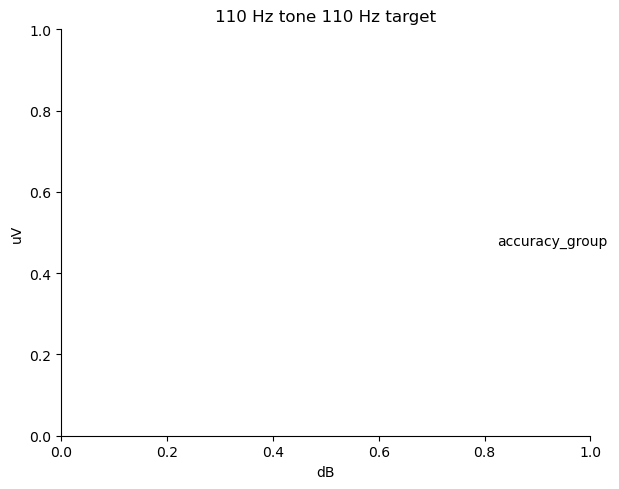

In [17]:
peak = all_peaks[(all_peaks.tone == 110) & (all_peaks.target == 110) & (all_peaks.start == 430)]
uV = peak.groupby(['subject', 'target', 'accuracy_group'], as_index=False)['uV'].mean()
dB = peak.groupby(['subject', 'target', 'accuracy_group'], as_index=False)['dB'].mean()
df = uV
df['dB'] = dB.dB

# Plot
sns.lmplot(data = df, x = "dB", y = "uV", hue = "accuracy_group")
ax = plt.gca()
ax.set_title("110 Hz tone 110 Hz target")
plt.tight_layout()
plt.savefig('../figs/ERP-FFR-tone-1-by-accuracy.png')

# Regression
df_low = df[df.accuracy_group == 'low']
slope, intercept, r_value, p_value, std_err = stats.linregress(df_low.dB, df_low.uV)
print(slope, intercept, r_value, p_value, std_err)
df_high = df[df.accuracy_group == 'high']
slope, intercept, r_value, p_value, std_err = stats.linregress(df_high.dB, df_high.uV)
print(slope, intercept, r_value, p_value, std_err)

In [ ]:
peak = all_peaks[(all_peaks.tone == 150) & (all_peaks.target == 150) & (all_peaks.start == 430)]
uV = peak.groupby(['subject', 'target', 'accuracy_group'], as_index=False)['uV'].mean()
dB = peak.groupby(['subject', 'target', 'accuracy_group'], as_index=False)['dB'].mean()
df = uV
df['dB'] = dB.dB

# Plot
sns.lmplot(data = df, x = "dB", y = "uV", hue = "accuracy_group")
ax = plt.gca()
ax.set_title("150 Hz tone 150 Hz target")
plt.tight_layout()
plt.savefig('../figs/ERP-FFR-tone-2-by-accuracy.png')

# Regression
df_low = df[df.accuracy_group == 'low']
slope, intercept, r_value, p_value, std_err = stats.linregress(df_low.dB, df_low.uV)
print(slope, intercept, r_value, p_value, std_err)
df_high = df[df.accuracy_group == 'high']
slope, intercept, r_value, p_value, std_err = stats.linregress(df_high.dB, df_high.uV)
print(slope, intercept, r_value, p_value, std_err)

In [ ]:
peak = all_peaks[(all_peaks.tone == 210) & (all_peaks.target == 210) & (all_peaks.start == 430)]
uV = peak.groupby(['subject', 'target', 'accuracy_group'], as_index=False)['uV'].mean()
dB = peak.groupby(['subject', 'target', 'accuracy_group'], as_index=False)['dB'].mean()
df = uV
df['dB'] = dB.dB

# Plot
sns.lmplot(data = df, x = "dB", y = "uV", hue = "accuracy_group")
ax = plt.gca()
ax.set_title("210 Hz tone 210 Hz target")
plt.tight_layout()
plt.savefig('../figs/ERP-FFR-tone-3-by-accuracy.png')

# Regression
df_low = df[df.accuracy_group == 'low']
slope, intercept, r_value, p_value, std_err = stats.linregress(df_low.dB, df_low.uV)
print(slope, intercept, r_value, p_value, std_err)
df_high = df[df.accuracy_group == 'high']
slope, intercept, r_value, p_value, std_err = stats.linregress(df_high.dB, df_high.uV)
print(slope, intercept, r_value, p_value, std_err)